# Resample ZARR datasets
This notebook gives a demonstration of how to resample zarr datasets.
## TOC:
* [1. Import packages](#1)
* [2. Settings](#2)
* [3. Resample on the fly](#3)
* [4. Resample using batches](#4)

#### Import resampling

## 1. Import packages <a class="anchor" id="1"></a>
#### Import standard packages

In [1]:
import os
import sys
import os.path
import xarray as xr
import pandas as pd
from pathlib import Path

#### Import Resampling modules
Before running this code, make sure your S3 credentials are stored in the config.toml. 

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import resampling

In [3]:
from resampling.plot_logs import plot_logs
from resampling.plot_zarr import plot_dataset
from resampling.my_store import store_from_config
from resampling.down_scale import down_scale_in_batches
from resampling.down_scale import down_scale_on_the_fly

## 2. Settings <a class="anchor" id="2"></a>
#### Initiate ObjectStore
Using get_my_store.get_my_store, we can initiate an instance of ObjectStore. The ObjectStore class will handle all IO to our S3 storage. ObjectStore can be initiated directly providing credentials, or get_my_store can be used, which imports the credentials from config/config.toml. <br><br>
**Notice not to expose your credentials!** <br>The credentials used and displayed in this tutorial are only valid for 24h and thus cause no security leak.

In [4]:
my_store = store_from_config("config.toml")

#### Target resolution <a class="anchor" id="2.0"></a>
Define the dimesion, ranges and resolution (step) to which the dataset should be resampled. <br>
Note that dimensions that are in the dataset but that are not mentioned in resampler will be maintained to the original resolution.

In [5]:
resampler = [
    {"dimension": "latitude",
     "range": (30, 70),
     "step": 0.5,
     "invert": True
     },
    {"dimension": "longitude",
     "range": (-10, 40),
     "step": 0.5
     },
]

## 3. Resample on the fly <a class="anchor" id="3"></a>
If a dataset is manageable to be read in momory without consuming to much RAM, it can be resampled in on the fly.
#### Define target dataset

In [6]:
url = "https://s3.waw3-1.cloudferro.com/emodnet/emodnet_arco/bio_oracle/sea_water_temperature/sea_water_temperature_bio_oracle_baseline_2000_2019/climatologydecadedepthsurf.zarr"
var = "average_sea_water_temperature_biooracle_baseline"

Open the dataset with xarray

In [7]:
ds = xr.open_zarr(url)
print(ds)

<xarray.Dataset> Size: 415MB
Dimensions:                                           (time: 2, latitude: 3600,
                                                       longitude: 7200)
Coordinates:
  * latitude                                          (latitude) float32 14kB ...
  * longitude                                         (longitude) float32 29kB ...
  * time                                              (time) datetime64[ns] 16B ...
Data variables:
    average_sea_water_temperature_biooracle_baseline  (time, latitude, longitude) float64 415MB dask.array<chunksize=(1, 2894, 5795), meta=np.ndarray>
Attributes: (12/13)
    Conventions:          CF-1.5
    comment:              Uses attributes recommended by http://cfconventions...
    experiment:           Baseline
    geographical_extent:  [-89, -179, 89, 179]
    history:              File created: 2021-12-15 00:34:56
    institution:          Bio-Oracle consortium: https://www.bio-oracle.org
    ...                   ...
    proj

#### Rescale dataset
Rescale the xarray dataset according the information from the resampler.

In [8]:
ds_downscaled = down_scale_on_the_fly(
    ds=ds,
    resampler=resampler
)

In [9]:
print(ds_downscaled)

<xarray.Dataset> Size: 129kB
Dimensions:                                           (time: 2, latitude: 80,
                                                       longitude: 100)
Coordinates:
  * time                                              (time) datetime64[ns] 16B ...
  * latitude                                          (latitude) float64 640B ...
  * longitude                                         (longitude) float64 800B ...
Data variables:
    average_sea_water_temperature_biooracle_baseline  (time, latitude, longitude) float64 128kB dask.array<chunksize=(1, 80, 100), meta=np.ndarray>
Attributes: (12/13)
    Conventions:          CF-1.5
    comment:              Uses attributes recommended by http://cfconventions...
    experiment:           Baseline
    geographical_extent:  [-89, -179, 89, 179]
    history:              File created: 2021-12-15 00:34:56
    institution:          Bio-Oracle consortium: https://www.bio-oracle.org
    ...                   ...
    proj:epsg:

Save the result to a new zarr. 

In [10]:
ds_name = "tutorial/resampled_SST_baseline"
my_store.write_zarr(dataset=ds_downscaled, name=f"{ds_name}.zarr")

## 4. Resample using batches <a class="anchor" id="4"></a>
When reading datasets that consume more RAM then you have available, it is not feasible to process them in memory. Instead, the dataset will be devided in batches (each containing #x windows) and each window will be processed seperate. 
### Define target dataset 

In [11]:
url = ("https://s3.waw3-1.cloudferro.com/emodnet/bathymetry/bathymetry_2022.zarr")
var = ["elevation"]

Open the dataset with xarray, notice that this ds consumes 66GB.

In [12]:
ds = xr.open_zarr(url)
print(ds)

<xarray.Dataset> Size: 66GB
Dimensions:        (latitude: 72000, longitude: 75840)
Coordinates:
  * latitude       (latitude) float64 576kB 15.0 15.0 15.0 ... 90.0 90.0 90.0
  * longitude      (longitude) float64 607kB -36.0 -36.0 -36.0 ... 43.0 43.0
Data variables:
    elevation      (latitude, longitude) float32 22GB dask.array<chunksize=(1125, 1185), meta=np.ndarray>
    elevation_max  (latitude, longitude) float32 22GB dask.array<chunksize=(1125, 1185), meta=np.ndarray>
    elevation_min  (latitude, longitude) float32 22GB dask.array<chunksize=(1125, 1185), meta=np.ndarray>
Attributes: (12/26)
    Conventions:                SeaDataNet_1.0 CF1.6
    EMODnet_Record_Identifier:  ff3aff8a-cff1-44a3-a2c8-1910bf109f85
    GetRecordByIdResponse:      \n  
    Record:                     \n    
    comment:                    The data in the EMODnet Grid should not be us...
    data_rights_constraints:    DO NOT USE FOR NAVIGATION
    ...                         ...
    sci:doi:          

Additional settings to regulate the window processing:
- workers: number of windows that will be processed in parallel. Each window will start a thread. Notice that the total number of thread will be larger than number of workers due to a number of background threads (especially since zarr is using Dask which will also open several threads).
- batch_size: number of windows to be processed before writing the results to the zarr. Small batch size will slow down the process because of the increasing amount of write operations. Large batch sizes could cause RAM errors.
#### Batch processing settings

In [13]:
params = {"resampler": resampler,
          "workers": 50,
          "batch_size": 500
         }

#### Process dataset
Attention! This step will take some time.<br>
You can track progress in the log_events.log. It keeps track of the number of batches that have been processed / to be processed.

In [14]:
dest_zarr = "tutorial/resampled_bathymetry.zarr"
down_scale_in_batches(
    my_store=my_store,
    ds=ds,
    dest_zarr=dest_zarr,
    variables=var,
    **params)

C:\Users\willem.boone\Documents\github_maintenance\resample_zarr\resampling\_define_windows.py:134: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for dim in ds.dims.keys():


>> Working on VAR elevation - batch 1/16:windows [0-500]/8000
>> Working on VAR elevation - batch 2/16:windows [500-1000]/8000
>> Working on VAR elevation - batch 3/16:windows [1000-1500]/8000
>> Working on VAR elevation - batch 4/16:windows [1500-2000]/8000
>> Working on VAR elevation - batch 5/16:windows [2000-2500]/8000
>> Working on VAR elevation - batch 6/16:windows [2500-3000]/8000
>> Working on VAR elevation - batch 7/16:windows [3000-3500]/8000
>> Working on VAR elevation - batch 8/16:windows [3500-4000]/8000
>> Working on VAR elevation - batch 9/16:windows [4000-4500]/8000
>> Working on VAR elevation - batch 10/16:windows [4500-5000]/8000
>> Working on VAR elevation - batch 11/16:windows [5000-5500]/8000
>> Working on VAR elevation - batch 12/16:windows [5500-6000]/8000
>> Working on VAR elevation - batch 13/16:windows [6000-6500]/8000
>> Working on VAR elevation - batch 14/16:windows [6500-7000]/8000
>> Working on VAR elevation - batch 15/16:windows [7000-7500]/8000
>> Workin

#### Inspect logs
In case your program crashes, you can plot the logs and inspect resource consumption in order to provide better settings for a retry.

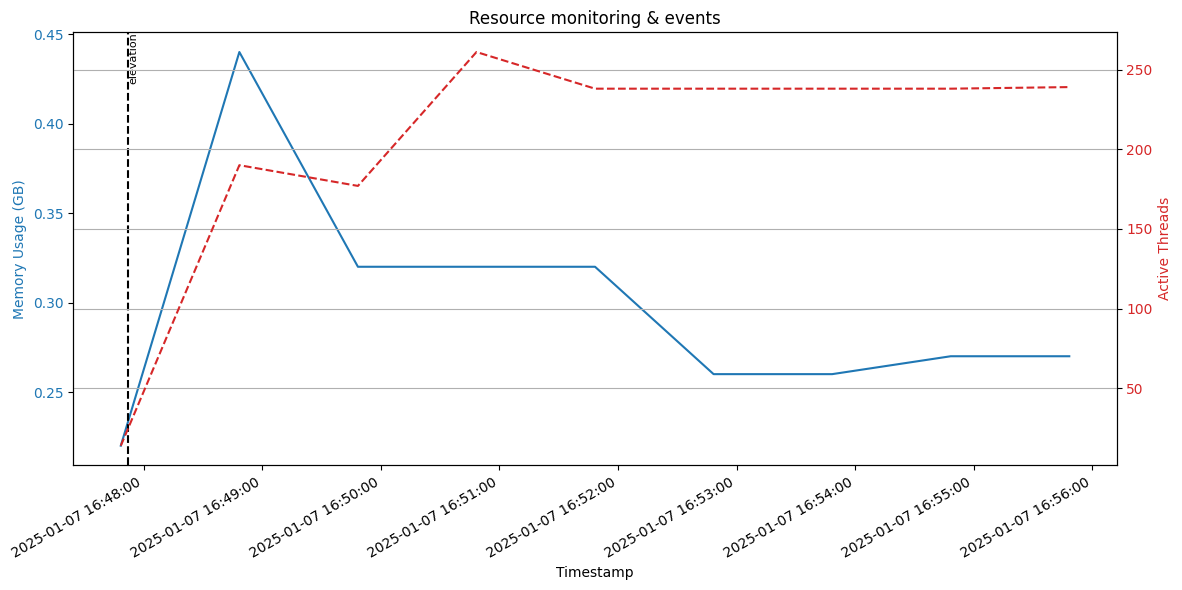

In [17]:
plot_logs(show=True)